# Tutorial introduction to variational state-space models


In [1]:
# load Python/Theano stuff
%load_ext autoreload 
# Show figures inline with the code
%matplotlib inline   

import theano
import theano.tensor as T
import theano.tensor.nlinalg as Tla
import lasagne       # the library we're using for NN's
# import the nonlinearities we might use 
from lasagne.nonlinearities import leaky_rectify, softmax, linear, tanh, rectify, sigmoid
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
from numpy.random import *
from matplotlib import pyplot as plt
import scipy.io
import cPickle
import sys
import funs
# I always initialize random variables here. 
msrng = RandomStreams(seed=20150503)
mnrng = np.random.RandomState(20150503)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\kdais\Anaconda3\envs\py27\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
theano.config.optimizer = 'fast_compile'

# Load our code

# Add all the paths that should matter right now
sys.path.append('lib')  # support files (mathematical tools, mostly)

from GenerativeModel import *       # Class file for generative models. 
from RecognitionModel import *      # Class file for recognition models
from SGVB import *                  # The meat of the algorithm - define the ELBO and initialize Gen/Rec model

# Generative models and sampling

The GenerativeModel.py file contains an abstract Generative model class, and implementations of a few example generative models: LDS (Kalman filter model), PLDS (LDS with Poisson count observations). The abstract GenerativeModel class describes all the functions you must implement to define a new GenerativeModel: methods for sampling from the model and and evaluating its log likelihood.


When initializing a new GenerativeModel instance, you define all its parameters in a dictionary. For the LDS and PLDS classes, most parameters have random initializations that will be used if they are not specified in the dictionary. 


Text(0.5,1,'observations')

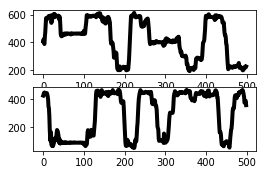

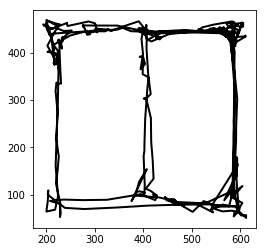

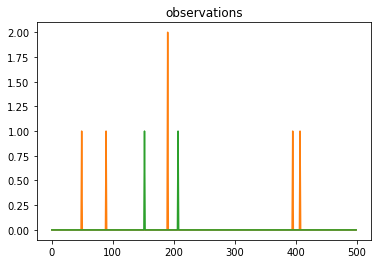

In [3]:
# Let's define a PLDS GenerativeModel. First, choose dimensionality of latent space and output:

xDim = 20
yDim = 44
time = 500
datax = scipy.io.loadmat("spike44_k09_500.mat")
z_true = scipy.io.loadmat("trj44_k09_500.mat")
####### Set up genertive model dictionary #######

# Define a neural network that maps the latent state into the output
gen_nn = lasagne.layers.InputLayer((None, xDim))
gen_nn = lasagne.layers.DenseLayer(gen_nn, yDim, nonlinearity=linear, W=lasagne.init.Orthogonal())
NN_XtoY_Params = dict([('network', gen_nn)])

# #Put all the parameters in a dictionary
gendict = dict([('A'     , 0.8*np.eye(xDim)),         # Linear dynamics parameters
                ('QChol' , 2*np.diag(np.ones(xDim))), # innovation noise
                ('Q0Chol', 2*np.diag(np.ones(xDim))), 
                ('x0'    , np.zeros(xDim)), 
#                ('RChol', np.ones(yDim)),             # observation covariance
                ('NN_XtoY_Params',NN_XtoY_Params),    # neural network output mapping
                ('output_nlin' , 'softplus')  # for poisson observations
                ])

# Instantiate a PLDS generative model:
true_model = PLDS(gendict, xDim, yDim, srng = msrng, nrng = mnrng)
#print(z_true)
x_data = z_true["trj44_k09_500"]
y_data = datax["spike44_k09_500"]
#print(y_data)
# and plot them
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(x_data[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(x_data[:, 1], lw=4, color='k')

plt.figure(figsize=(4, 4))
plt.plot(*x_data.T, lw = 2, color='k')
plt.figure()
plt.plot(y_data[:time,:3])
plt.title('observations')

#true_model.evaluateLogDensity(x_data[:100], y_data[:100]).eval()

# Recognition Model ("approximate posterior")


Our goal is to learn the parameters of $p_\theta(y|x)$ and the posterior $p(x|y)$. 

Since the posterior is hard to compute for most generative models, we approximate it using a Gaussian. Because we're interested in timeseries, we've designed our approximation to be able to express temporal correlations in a computationally fast way. In the code, we call this the "SmoothingTimeSeries" and "SmoothingLDSTimeSeries" recognition models (corresponding to the two parameterizations in Sec. 4 of the paper). 


Text(0.5,1,'samples from an untrained approximate posterior')

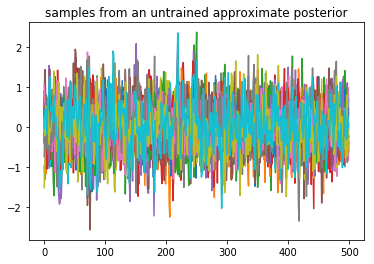

In [4]:
########################################
hidden = 30
# Describe network for mapping into means
NN_Mu = lasagne.layers.InputLayer((None, yDim))
NN_Mu = lasagne.layers.DenseLayer(NN_Mu, hidden, nonlinearity=tanh, W=lasagne.init.Orthogonal())
#--------------------------------------
# let's initialize the first layer to have 0 mean wrt our training data
W0 = np.asarray(NN_Mu.W.get_value(), dtype=theano.config.floatX)
NN_Mu.W.set_value( (W0 / np.dot(y_data, W0).std(axis=0)).astype(theano.config.floatX) )
W0 = np.asarray(NN_Mu.W.get_value(), dtype=theano.config.floatX)
b0 = (-np.dot(y_data, W0).mean(axis=0)).astype(theano.config.floatX)
NN_Mu.b.set_value(b0)
#--------------------------------------
NN_Mu = lasagne.layers.DenseLayer(NN_Mu, xDim, nonlinearity=linear, W=lasagne.init.Normal())
NN_Mu.W.set_value(NN_Mu.W.get_value()*10)
NN_Mu = dict([('network', NN_Mu)])

########################################
# Describe network for mapping into Covariances
NN_Lambda = lasagne.layers.InputLayer((None, yDim))
NN_Lambda = lasagne.layers.DenseLayer(NN_Lambda, hidden, nonlinearity=tanh, W=lasagne.init.Orthogonal())
#--------------------------------------
# let's initialize the first layer to have 0 mean wrt our training data
W0 = np.asarray(NN_Lambda.W.get_value(), dtype=theano.config.floatX)
NN_Lambda.W.set_value( (W0 / np.dot(y_data, W0).std(axis=0)).astype(theano.config.floatX) )
W0 = np.asarray(NN_Lambda.W.get_value(), dtype=theano.config.floatX)
b0 = (-np.dot(y_data, W0).mean(axis=0)).astype(theano.config.floatX)
NN_Lambda.b.set_value(b0)
#--------------------------------------
NN_Lambda = lasagne.layers.DenseLayer(NN_Lambda, xDim*xDim, nonlinearity=linear, W=lasagne.init.Orthogonal())
NN_Lambda.W.set_value(NN_Lambda.W.get_value()*10)
NN_Lambda = dict([('network', NN_Lambda)])

########################################
# define dictionary of recognition model parameters
recdict = dict([('A'     , .9*np.eye(xDim)),
                ('QinvChol',  np.eye(xDim)), #np.linalg.cholesky(np.linalg.inv(np.array(tQ)))),
                ('Q0invChol', np.eye(xDim)), #np.linalg.cholesky(np.linalg.inv(np.array(tQ0)))),
                ('NN_Mu' ,NN_Mu),
                ('NN_Lambda',NN_Lambda),
                ])

########################################
# We can instantiate a recognition model alone and sample from it. 
# First, we have to define a Theano dummy variable for the input observations the posterior expects:
Y = T.matrix()

rec_model = SmoothingLDSTimeSeries(recdict, Y, xDim, yDim, srng = msrng, nrng = mnrng)
rsamp = rec_model.getSample()

# to look at a sample, we have to evaluate it at data:
plt.figure()
plt.plot(rsamp.eval({Y: y_data[:500]})) # here, the data are mapping into the parameters
plt.title('samples from an untrained approximate posterior')


We train the generative model and recognition model together using gradient descent. We wrapped the SGVB objective function in the SGVB class. To train a generative and recognition model on data, we instantiate an instance of SGVB, passing in the GenerativeModel and RecognitionModel we wish to use (along with parameter dictionaries). 

In [5]:
# initialize training with a random generative model (that we haven't generated data from):
initGenDict = dict([
             ('output_nlin' , 'softplus')  
                 ])

# Instantiate an SGVB class:
sgvb = SGVB(initGenDict, PLDS, recdict, SmoothingLDSTimeSeries, xDim = xDim, yDim = yDim)

In [6]:
########################################
# Define a helper class to help us iterate through the training data
class DatasetMiniBatchIndexIterator(object):
    """ Basic mini-batch iterator """
    def __init__(self, y, batch_size=100, randomize=False):
        self.y = y
        self.batch_size = batch_size
        self.randomize = randomize
        from sklearn.utils import check_random_state
        self.rng = np.random.RandomState(np.random.randint(12039210))

    def __iter__(self):
        n_samples = self.y.shape[0]
        #if n_samples == self.batch_size:
        #    yield [self.y, np.arange(n_samples)]
        if self.randomize:
            for _ in xrange(n_samples / self.batch_size):
                if self.batch_size > 1:
                    i = int(self.rng.rand(1) * ((n_samples-self.batch_size-1)))
                else:
                    i = int(math.floor(self.rng.rand(1) * n_samples))
                ii = np.arange(i, i + self.batch_size)
                yield [self.y[ii], ii]
        else:
            for i in xrange((n_samples + self.batch_size - 1)
                            / self.batch_size):
                ii = np.arange(i*self.batch_size,(i+1)*self.batch_size)
                yield [self.y[ii], ii]

In [7]:
########################################
# Define a bare-bones thenao training function
batch_y = T.matrix('batch_y')

########################################
# choose learning rate and batch size
learning_rate = 1e-3
batch_size = 100

########################################
# use lasagne to get adam updates
updates = lasagne.updates.adam(-sgvb.cost(), sgvb.getParams(), learning_rate=learning_rate)

########################################
# Finally, compile the function that will actually take gradient steps. 
train_fn = theano.function(
         outputs=sgvb.cost(),
         inputs=[theano.In(batch_y)],
         updates=updates,
         givens={sgvb.Y: batch_y},
    )

TypeError: bad operand type for unary -: 'tuple'

In [ ]:
########################################
# set up an iterator over our training data
yiter = DatasetMiniBatchIndexIterator(y_data, batch_size=batch_size, randomize=True)

########################################
# Iterate over the training data for the specified number of epochs
n_epochs = 100
cost = []
for ie in np.arange(n_epochs):
    print('--> entering epoch %d' % ie)
    for y, _ in yiter:
        cost.append(train_fn(y))
        #print cost[-1]

In [ ]:
########################################
# Iterate over the training data for the specified number of epochs
plt.plot(cost[1:])
plt.title('ELBO vs iteration')
plt.xlabel('iteration number')
plt.ylabel('Evidence Lower Bound (ELBO)')

We can access the trained generative and recognition models through the SGVB object, just as before.

In [ ]:
#########################
# Since the model is non-identifiable, let's find the best linear projection from the
# learned posterior mean into the 'true' training-data latents
pM = sgvb.mrec.postX.eval({sgvb.Y: y_data})
wgt = np.linalg.lstsq(pM-pM.mean(), x_data-x_data.mean())[0]   

In [ ]:
######################### 
x_test = x_data
y_test = y_data
#########################
# sample from the trained recognition model
rtrain_samp = sgvb.mrec.getSample()

plt.figure()
plt.hold('on')

#########################
import funs
# plot 25 samples from the posterior
#for idx in np.arange(25): # plot multiple samples from the posterior
    #xs = rtrain_samp.eval({sgvb.Y: y_test})
    #plt.plot(np.dot(xs,wgt),'k')
# and now plot the posterior mean
pMtest = sgvb.mrec.postX.eval({sgvb.Y: y_test})
plt.subplot(211)
plt_post = plt.plot(np.dot(pMtest,wgt)[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(x_test[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(np.dot(pMtest,wgt)[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(x_test[:,1], 'k', linewidth = 3, label = '\"true\" mean')

plt.legend(handles = plt_post + plt_true)
plt.xlabel('time')
plt.title('samples from the trained approximate posterior')
qz_mean_est = np.dot(pMtest,wgt)
qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))

z_true_c = x_test - x_test.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)

R = funs.compute_optimal_rotation(np.stack(qz_est_norm), z_true_norm, scale=True)
qz_est_norm_R = qz_est_norm#np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
fig = plt.figure()
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[:,0], qz_est_norm_R[:,1], lw=2, color = 'r')